In [1]:
import glob
import os
import pandas as pd
import numpy as np

## Prepare Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Machine learning model
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Machine learning model evaluation
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, confusion_matrix

## Metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

## plot graphs
import matplotlib.pyplot as plt
import seaborn as sns
import csv

from sklearn.preprocessing import LabelEncoder

In [2]:
### Functions

files_relative_path = 'data2/'

file_name = 'IDS.csv'
files_names = ['LDAP.csv', 'MSSQL.csv', 'NetBIOS.csv', 'Portmap.csv', 'Syn.csv', 'UDP.csv', 'UDPLag.csv']


def load_dataset(file_path, file_name, nrows=10000000):
    full_path = os.path.join(file_path, file_name)
    data_set = pd.read_csv(full_path, header=0, nrows=nrows, dtype={'Column85': str}, low_memory=False)
    
    data_set.columns = data_set.columns.str.strip()
    
    return data_set

def get_samples_by_label(data_frame, label):
    data_frame.columns = data_frame.columns.str.strip()
    
    filtered_samples = data_frame[data_frame["Label"] == label]
    
    return filtered_samples

def combine_datasets(file_path, file_names, nrows=15000):
    
    dataframes = []
    
    for name in file_names:
        try:
            df = load_dataset(file_path, name, nrows)
            dataframes.append(df)
        except Exception as e:
            print(f"Error reading {os.path.join(file_path, name)}: {e}")
    
    combined_df = pd.concat(dataframes, ignore_index=True)
    combined_df.columns = combined_df.columns.str.strip()
    
    return combined_df


def calculate_label_distribution(dataframe, label_column):
    total_samples = dataframe.shape[0]
    label_counts = dataframe[label_column].value_counts()
    
    distribution = {}
    for label, count in label_counts.items():
        percentage = (count / total_samples) * 100
        distribution[label] = {
            'count': count,
            'percentage': percentage
        }
        
    return distribution

def display_label_distribution(label_distribution):
    for label, stats in label_distribution.items():
        print(f"Samples Count: {label}: {stats['count']}")
        print(f"Percentage distribution of data: {label}: {stats['percentage']:.2f}%")
    

def display_unique_labels(data_frame):
    unique_labels = data_frame["Label"].unique()
    print("Unique Labels:", unique_labels)

def display_dataset_length(data_frame):
    length = len(data_frame)
    print("Dataset length:", length)

In [3]:

def visualize_nulls(data_frame):
    null_counts = data_frame.isna().sum()
    total_rows = len(data_frame)
    
    # Filtrujemy kolumny z wartościami null
    null_counts = null_counts[null_counts > 0]
    
    # Sprawdzenie, czy są jakiekolwiek wartości null
    if null_counts.empty:
        print("No null value in the dataset.")
        return

    # Liczba kolumn z wartościami null
    num_null_columns = (null_counts > 0).sum()
    print(f"Liczba kolumn z wartościami null: {num_null_columns}")
    
    # Obliczamy procentowe udziały
    null_percentage = (null_counts / total_rows) * 100
    
    # Tworzymy DataFrame do wizualizacji
    null_summary = pd.DataFrame({
        'Null Count': null_counts,
        'Null Percentage': null_percentage
    })
    
    # Wizualizacja
    plt.figure(figsize=(12, 6))
    null_summary['Null Count'].plot(kind='bar', color='skyblue', alpha=0.7, label='Liczba Nulli')
    plt.ylabel('Number of Null')
    
    # Dodanie drugiej osi dla procentów
    ax2 = plt.gca().twinx()
    null_summary['Null Percentage'].plot(kind='line', marker='o', color='orange', ax=ax2, label='Procent Nulli')
    ax2.set_ylabel('Procent Nulli (%)')
    
    plt.title('Number and Percentage of Null Values in Features')
    plt.xticks(rotation=45)
    
    # Legenda
    plt.legend(loc='upper left')
    
    plt.show()

def visualize_labels(data_frame):
    # Zliczanie próbek dla każdej etykiety
    label_counts = data_frame['Label'].value_counts()

    # Ustawienie stylu wykresu
    sns.set(style="whitegrid")

    # Tworzenie wykresu słupkowego
    plt.figure(figsize=(10, 6))
    
    # Użycie hue dla poprawnej wizualizacji
    ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis", hue=label_counts.index, legend=False)

    # Dodawanie etykiet do słupków
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', fontsize=12)

    # Dodawanie tytułu i etykiet osi
    plt.title('Distribution of samples', fontsize=16)
    plt.xlabel('Attack type', fontsize=14)
    plt.ylabel('Number of Cases', fontsize=14)
    
    # Ustawienie osi X na poziomie 0.5 dla lepszej czytelności
    plt.xticks(rotation=45)
    
    # Wyświetlenie wykresu
    plt.tight_layout()
    plt.show()

In [4]:
combined_df = combine_datasets(files_relative_path, files_names)

display_unique_labels(combined_df)
display_dataset_length(combined_df)

label_distribution = calculate_label_distribution(combined_df, 'Label')
display_label_distribution(label_distribution)

Unique Labels: ['NetBIOS' 'BENIGN' 'LDAP' 'MSSQL' 'Portmap' 'Syn' 'UDP']
Dataset length: 105000
Samples Count: NetBIOS: 29965
Percentage distribution of data: NetBIOS: 28.54%
Samples Count: MSSQL: 19659
Percentage distribution of data: MSSQL: 18.72%
Samples Count: Syn: 15000
Percentage distribution of data: Syn: 14.29%
Samples Count: UDP: 14999
Percentage distribution of data: UDP: 14.28%
Samples Count: Portmap: 10285
Percentage distribution of data: Portmap: 9.80%
Samples Count: LDAP: 9931
Percentage distribution of data: LDAP: 9.46%
Samples Count: BENIGN: 5161
Percentage distribution of data: BENIGN: 4.92%


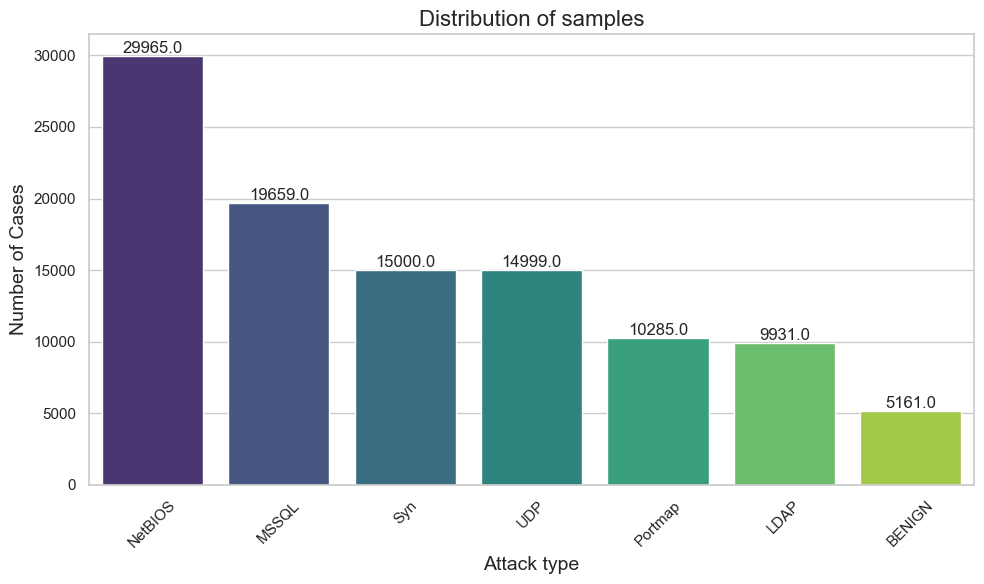

In [5]:
visualize_labels(combined_df)

In [6]:
first_dataset = load_dataset(files_relative_path, file_name)

# Adding “non-malignant” samples from another dataset to even out the ratio
benign_samples = get_samples_by_label(first_dataset, "BENIGN")

new_combined_df = pd.concat([combined_df, benign_samples], ignore_index=True)

display_dataset_length(new_combined_df)
label_distribution = calculate_label_distribution(new_combined_df, 'Label')
display_label_distribution(label_distribution)

Dataset length: 202718
Samples Count: BENIGN: 102879
Percentage distribution of data: BENIGN: 50.75%
Samples Count: NetBIOS: 29965
Percentage distribution of data: NetBIOS: 14.78%
Samples Count: MSSQL: 19659
Percentage distribution of data: MSSQL: 9.70%
Samples Count: Syn: 15000
Percentage distribution of data: Syn: 7.40%
Samples Count: UDP: 14999
Percentage distribution of data: UDP: 7.40%
Samples Count: Portmap: 10285
Percentage distribution of data: Portmap: 5.07%
Samples Count: LDAP: 9931
Percentage distribution of data: LDAP: 4.90%


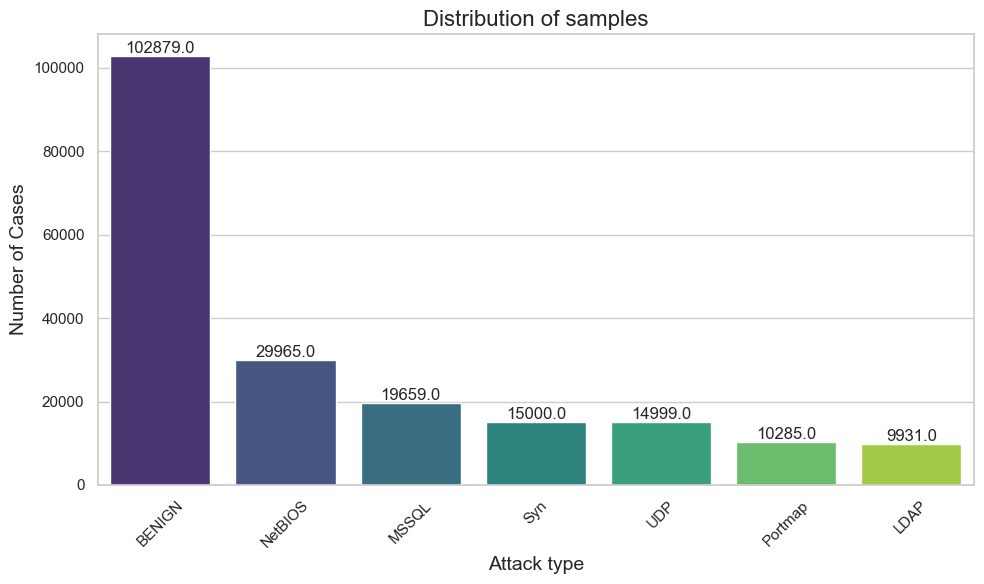

In [160]:
visualize_labels(new_combined_df)

Liczba kolumn z wartościami null: 10


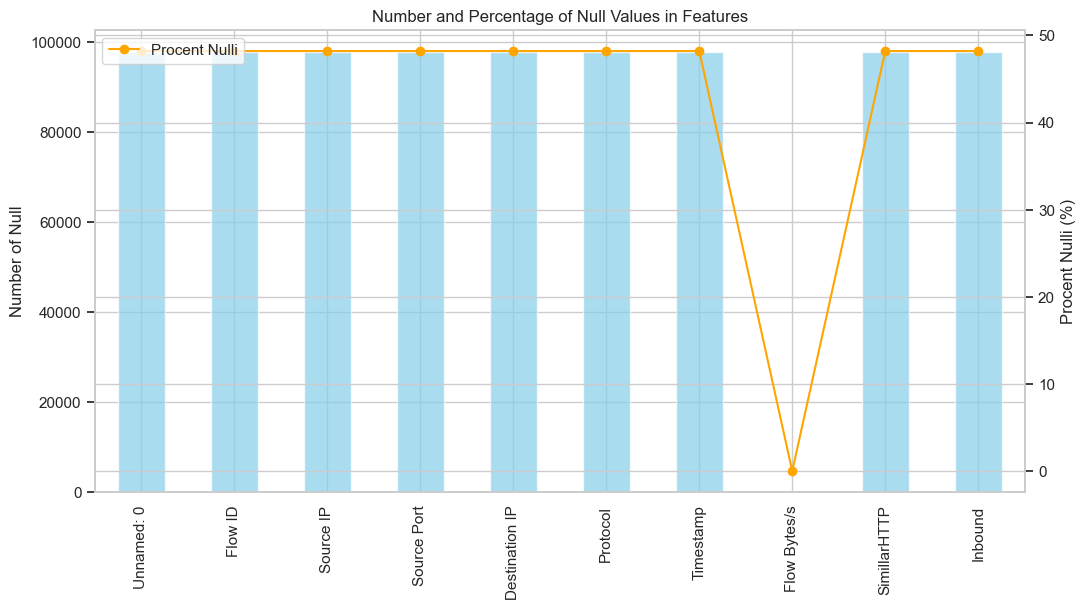

In [7]:
visualize_nulls(new_combined_df)

# Data Preprocessing

Dataset length: 202718
Liczba kolumn z wartościami null: 5


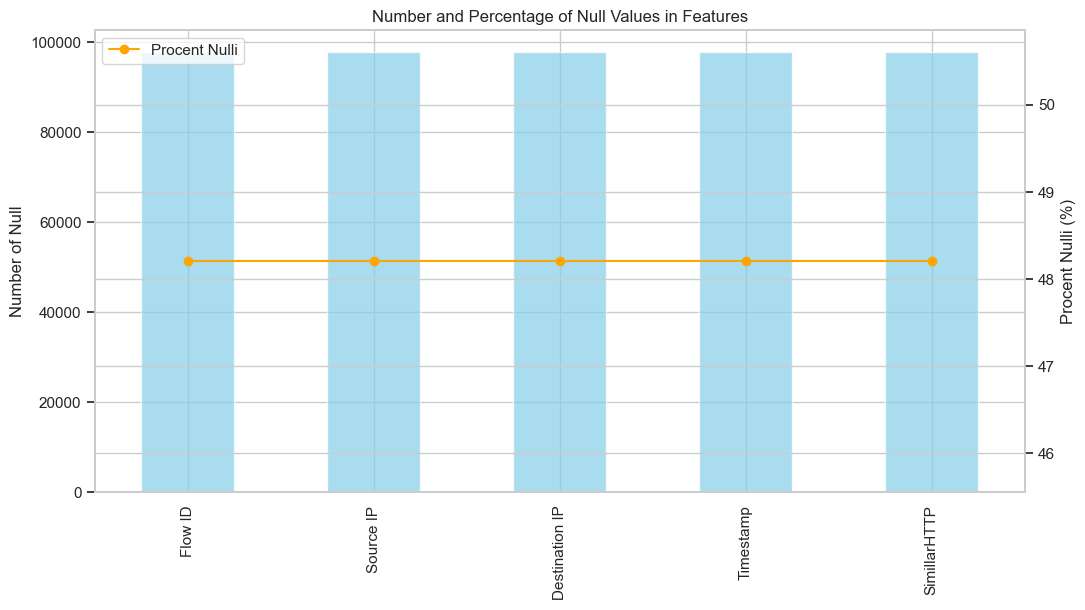

In [8]:
def imputation_missing_values(data_frame):
    # Converting inf to NaN
    data_frame.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Imputation of missing values for number type features (example: use of median)
    for column in data_frame.select_dtypes(include=[np.number]).columns:
        median_value = data_frame[column].median()
        data_frame[column] = data_frame[column].fillna(median_value)
   
    return data_frame

def check_none_numerican_columns(data_frame):
    object_columns = data_frame.select_dtypes(include=['object']).columns
    
    if not object_columns.empty:
        print("Columns with typecobject:", object_columns)
    else:
       print("DataSet does not have any columns with values: Nan")

    return 

new_combined_df = imputation_missing_values(new_combined_df)

display_dataset_length(new_combined_df)

visualize_nulls(new_combined_df)

In [110]:
check_none_numerican_columns(new_combined_df)

Columns with typecobject: Index(['Flow ID', 'Source IP', 'Destination IP', 'Timestamp', 'SimillarHTTP',
       'Label'],
      dtype='object')


In [10]:
# def remove_high_missing_columns(data_frame, threshold=0.3):
#     # Obliczamy próg brakujących wartości
#     missing_percentage = data_frame.isnull().mean()
    
#     # Identyfikujemy kolumny do usunięcia
#     columns_to_remove = missing_percentage[missing_percentage >= threshold].index.tolist()
    
#     # Usuwamy kolumny
#     data_frame_cleaned = data_frame.drop(columns=columns_to_remove)
    
#     # Usuwamy wiersze, które mają NaN w pozostałych kolumnach
#     data_frame_cleaned.dropna(inplace=True)
    
#     print(f"Deleted columns: {columns_to_remove}")
    
#     return data_frame_cleaned

# cleaned_df = remove_high_missing_columns(new_data_set, threshold=0.4)

In [109]:
def replace_missing_columns_most_common_value(data_frame, threshold=0.3):
    # Obliczamy próg brakujących wartości
    missing_percentage = data_frame.isnull().mean()
    
    # Identyfikujemy kolumny z dużą ilością NaN
    columns_to_replace = missing_percentage[missing_percentage >= threshold].index.tolist()
    
    for column in columns_to_replace:
        # Zastępujemy NaN najczęściej występującą wartością
        most_frequent_value = data_frame[column].mode()[0]  # Pobieramy najczęściej występującą wartość

        most_frequent_count = data_frame[column].value_counts().iloc[0]  # Liczba wystąpień najczęstszej wartości
                
        print(f"Most frequent value - {most_frequent_value} for column - {column} with count - {most_frequent_count}")
        data_frame[column] = data_frame[column].fillna(most_frequent_value)  # Zastępujemy NaN
        
    print(f"Replaced NaN values in columns: {columns_to_replace}")
    
    return data_frame

In [12]:
clear_data_set = replace_missing_columns_most_common_value(new_combined_df, threshold=0.4)

visualize_nulls(clear_data_set)

Most frequent value - 172.16.0.5-192.168.50.4-0-0-0 for column - Flow ID with count - 26
Most frequent value - 172.16.0.5 for column - Source IP with count - 99203
Most frequent value - 192.168.50.4 for column - Destination IP with count - 99209
Most frequent value - 2018-11-03 09:38:23.186376 for column - Timestamp with count - 2
Most frequent value - 0 for column - SimillarHTTP with count - 75000
Replaced NaN values in columns: ['Flow ID', 'Source IP', 'Destination IP', 'Timestamp', 'SimillarHTTP']
No null value in the dataset.


In [113]:
# Drop columns - It seems to me that these features should not make any difference to our model
# Further features that are not relevant will be shown in the first evaluation

clear_data_set = clear_data_set.drop(columns=['Unnamed: 0', 'Flow ID', 'Timestamp'], errors='ignore', axis=1)

# Verify removal
print(clear_data_set.columns)

Index(['Source IP', 'Source Port', 'Destination IP', 'Destination Port',
       'Protocol', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std'

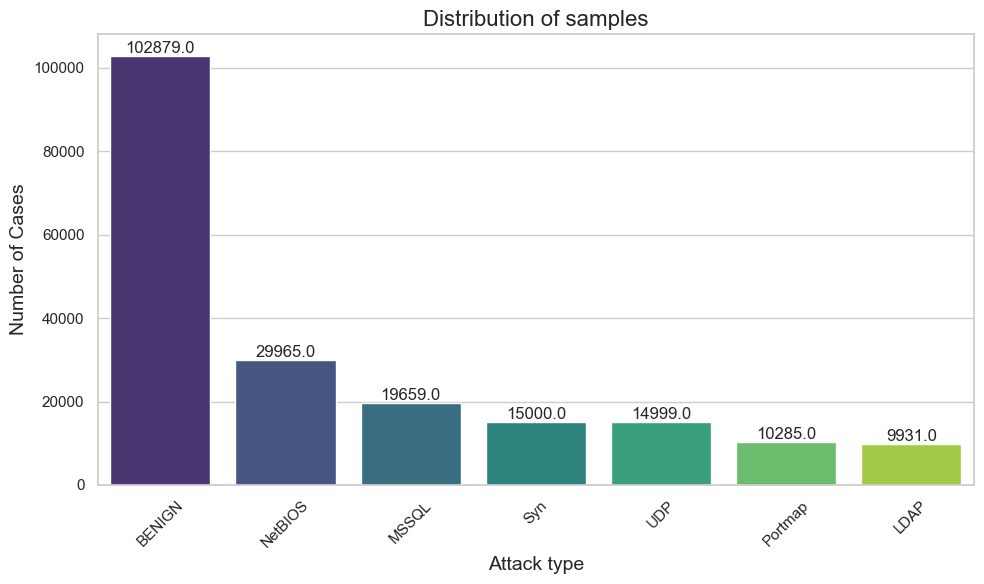

In [46]:
 visualize_labels(clear_data_set)

In [17]:
## Convert Label to numerical values - Benign in the context of personal data means “non-malignant"
def map_label(df):
    df['Label'] = df['Label'].apply(lambda x: 0 if x == "BENIGN" else 1)
    return df   

In [47]:
mapped_df = map_label(clear_data_set.copy())

mapped_df['Label'].unique()

array([1, 0])

# Visualization Data

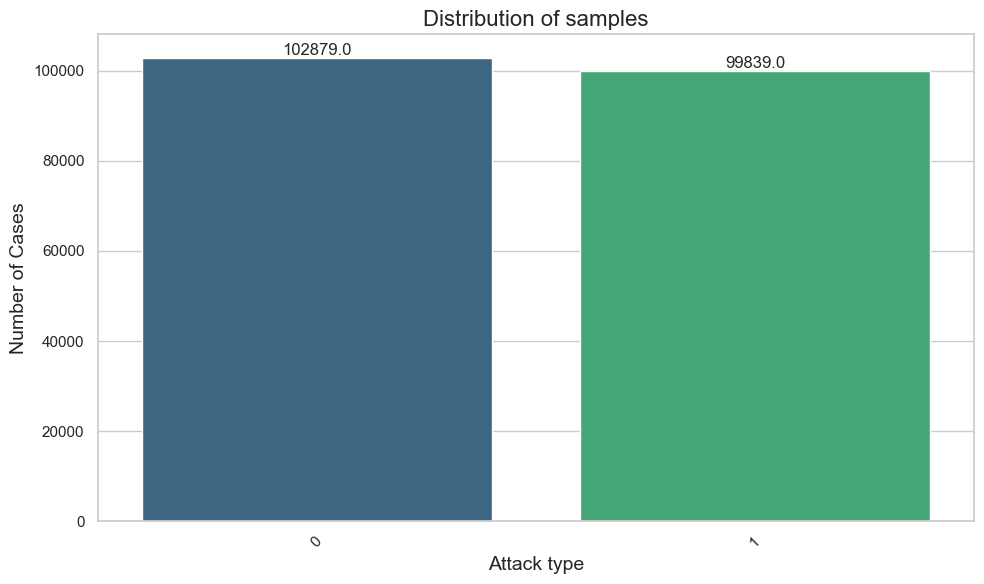

In [48]:
# Calling the visualization function
visualize_labels(mapped_df)

In [20]:
def encode_object_columns(df):
    
    # Inicjalizacja LabelEncoder
    label_encoder = LabelEncoder()

    # Wyszukiwanie kolumn o typie obiektowym
    object_columns = df.select_dtypes(include=['object']).columns

    # Przekształcanie każdej kolumny obiektowej
    for column in object_columns:
        df[column] = label_encoder.fit_transform(df[column].astype(str))

    return df

In [51]:
new_dataset = encode_object_columns(mapped_df)

# Data splitting into training and test

In [52]:
## Feature and Target variable
X = mapped_df.drop('Label', axis=1)
Y = mapped_df['Label']

## Convert to numPy array
x1 = np.array(X).astype(np.float64)
y1 = np.array(Y)

## Always check dataset length
assert len(X) == len(Y), "Długości zestawów cech i etykiet nie są zgodne."

In [53]:
## Split data into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

## Check
train_persent = len(X_train) / len(mapped_df) * 100
test_percent = len(X_test) / len(mapped_df) * 100

print("Train", train_persent)
print("Test", test_percent)

Train 69.99970402233645
Test 30.000295977663555


In [54]:
print("Train dataset size", X_train.shape)
print("Test dataset size", X_test.shape)

Train dataset size (141902, 84)
Test dataset size (60816, 84)


# Training Model

## I model - Random Forest


In [55]:
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)
rf_model.fit(X_train, Y_train)
rf_pred = rf_model.predict(X_test)
rf_pred

array([0, 0, 0, ..., 1, 0, 1])

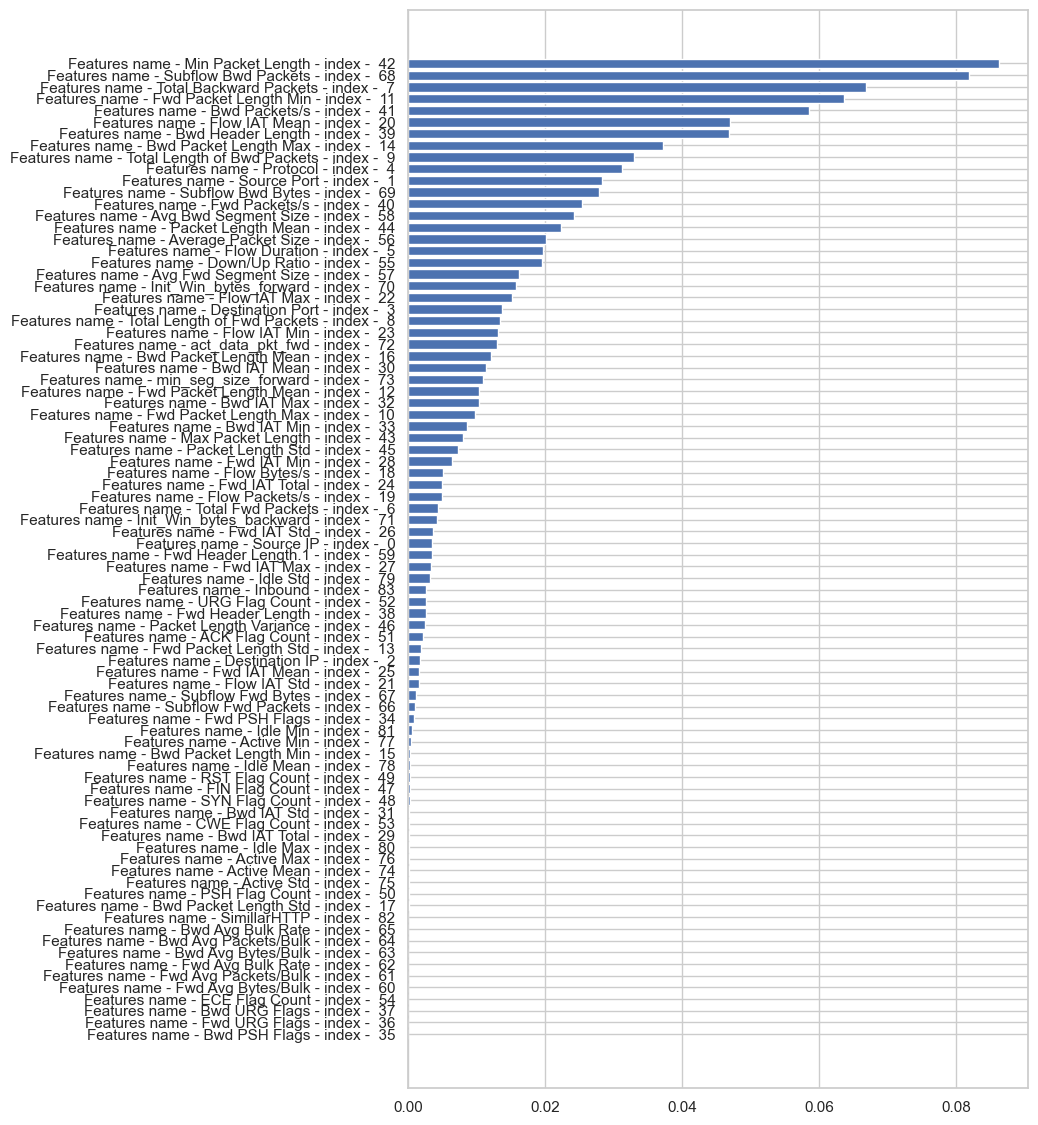

In [108]:
## importances feature from the model
importances = rf_model.feature_importances_

## sorted by importance
indexes = sorted(range(len(importances)), key=lambda i: importances[i], reverse=False)
feature_column_names = [f"Features name - {mapped_df.columns[i]} - index -  {i}" for i in indexes]

plt.figure(figsize=(8, 14))
plt.barh(range(X_train.shape[1]), importances[indexes], align="center")
plt.yticks(range(X_train.shape[1]), feature_column_names)
plt.show()

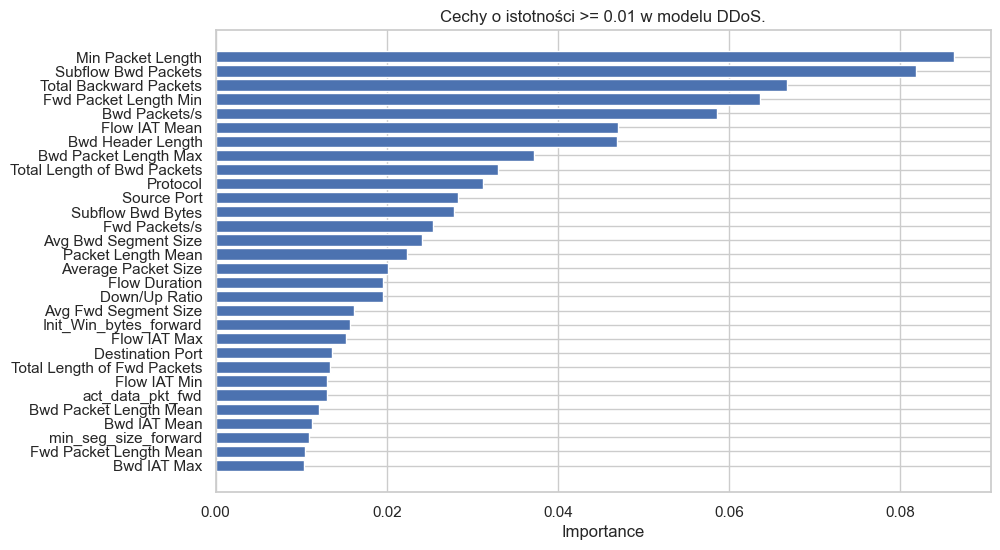

In [107]:
def extract_important_features(model, mapped_df, threshold=0.01):
    # Importances feature from the model
    importances = model.feature_importances_
    
    # Get the indices of features that meet the threshold
    indices = np.where(importances >= threshold)[0]  # Get indices of features with importance >= threshold
    
    # If no features meet the threshold, return a message
    if len(indices) == 0:
        print("Brak cech o istotności >= {}.".format(threshold))
        return

    # Get feature names and importances of the selected features
    important_feature_names = [mapped_df.columns[i] for i in indices]
    important_importances = importances[indices]

    # Sort features by importance in descending order
    sorted_indices = np.argsort(important_importances)
    sorted_feature_names = [important_feature_names[i] for i in sorted_indices]
    sorted_importances = important_importances[sorted_indices]
    
    # Create a horizontal bar plot for the important features
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_feature_names, sorted_importances, align='center')
    plt.xlabel('Importance')
    plt.title('Cechy o istotności >= {} w modelu DDoS.'.format(threshold))
    plt.show()

# Wywołanie funkcji z modelem rf_model
extract_important_features(rf_model, mapped_df)

Wybór istotnych cech w modelu DDoS
Aby określić, które cechy są istotne dla modelu detekcji ataków DDoS, warto przyjąć pewien próg dla wartości ważności cech. W przypadku modeli opartych na drzewach decyzyjnych, takich jak Random Forest, można wykorzystać wartości ważności cech (feature importances) do oceny ich wpływu na model.

- Próg 0.05 (5%):
Cechy o ważności powyżej 5% są zazwyczaj uznawane za istotne. Ten próg jest często stosowany w praktyce i może pomóc w redukcji liczby cech do tych, które mają bardziej znaczący wpływ na wyniki modelu.

- Próg 0.1 (10%):
Cechy o ważności powyżej 10% są zdecydowanie istotne i powinny być brane pod uwagę w kolejnych iteracjach modelowania. Umożliwia to skoncentrowanie się na tych cechach, które mają największy wpływ na wydajność modelu.


- Próg 0.2 (20%):
Cechy o ważności powyżej 20% mogą być uznawane za kluczowe dla modelu. Wybór tylko tych cech może prowadzić do uproszczenia modelu i poprawy interpretowalności

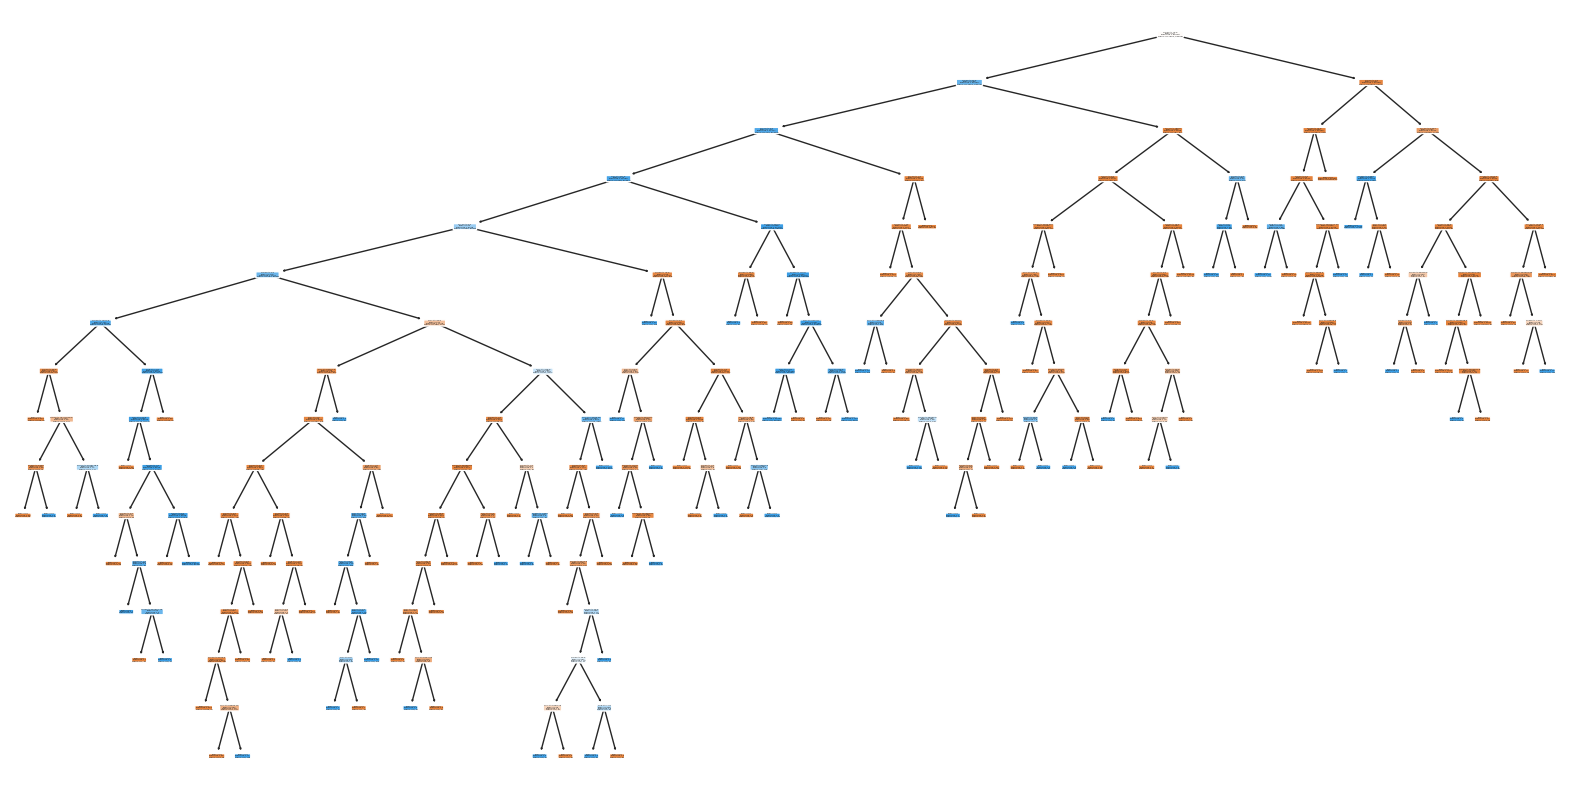

In [93]:
from sklearn.tree import plot_tree

estimator = rf_model.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(estimator, filled=True, rounded=True)

plt.show()

# Model Evaluation

In [58]:
 ## Generate and display a detailed confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [60]:
rf_accuracy = accuracy_score(Y_test, rf_pred)
rf_f1 = f1_score(Y_test, rf_pred)
rf_precision = precision_score(Y_test, rf_pred)
rf_recall = recall_score(Y_test, rf_pred)

def visualizationMetrics(accuracy, f1, precision, recall):
   metrics_data = {
    'Metric': ['Accuracy', 'F1 Score', 'Precision', 'Recall'],
    'Value': [accuracy, f1, precision, recall]
    }

   df_metrics = pd.DataFrame(metrics_data)

   print(df_metrics)

visualizationMetrics(rf_accuracy,rf_f1,rf_precision, rf_recall)

      Metric     Value
0   Accuracy  0.999901
1   F1 Score  0.999900
2  Precision  1.000000
3     Recall  0.999799


### Visualization

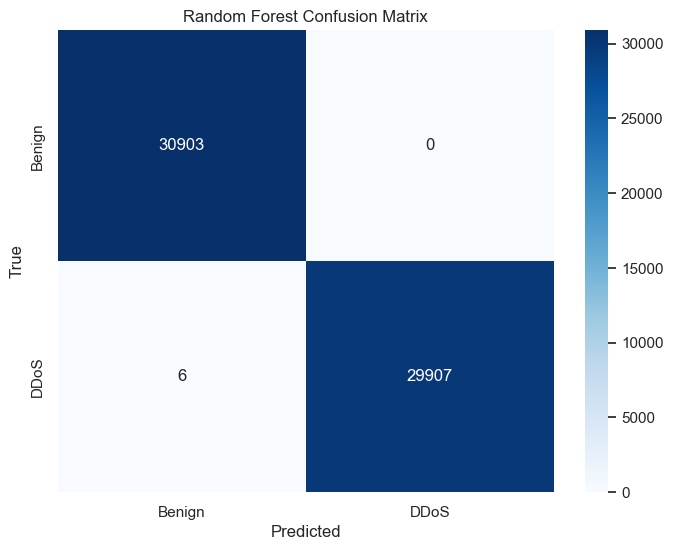

In [94]:
plot_confusion_matrix(Y_test, rf_pred, ['Benign', 'DDoS'], "Random Forest Confusion Matrix")

### II model - Logistic Regression

In [96]:
# lr_model = LogisticRegression(random_state=42)
# lr_model.fit(X_train, Y_train)
# lr_pred = lr_model.predict(X_test)


### Evaluate Logistic Regression

In [95]:
# lr_accuracy = accuracy_score(Y_test, lr_pred)
# lr_f1 = f1_score(Y_test, lr_pred)
# lr_precision = precision_score(Y_test, lr_pred)
# lr_recall = recall_score(Y_test, lr_pred)

In [97]:


# visualizationMetrics(lr_accuracy, lr_f1, lr_precision, lr_recall)

### Visualization

In [98]:
# plot_confusion_matrix(Y_test, lr_pred, ['Benign', 'DDoS'], "Logistic Regression Confusion Matrix")

###  Neural Network

In [99]:
# nn_model = MLPClassifier(hidden_layer_sizes=10, max_iter=10, random_state=42)
# nn_model.fit(X_train, Y_train)
# nn_pred = nn_model.predict(X_test)

### Evaluate Neural Network

In [100]:
# nn_accuracy = accuracy_score(Y_test, nn_pred)
# nn_f1 = f1_score(Y_test, nn_pred)
# nn_precision = precision_score(Y_test, nn_pred)
# nn_recall = recall_score(Y_test, nn_pred)

# visualizationMetrics(nn_accuracy, nn_f1, nn_precision, nn_recall)

### Visualization

In [101]:
# plot_confusion_matrix(Y_test, nn_pred, ['Benign', 'DDoS'], "Neural Network Confusion Matrix")

### Model Comparison

In [102]:

# rf_proba = rf_model.predict_proba(X_test)

# lr_proba = lr_model.predict_proba(X_test)

# nn_proba = nn_model.predict_proba(X_test)

### Prediction for ROC Curve

In [103]:
# rf_fp ,rf_tp, _ = roc_curve(Y_test, rf_proba[:, 1])
# rf_auc = auc(rf_fp, rf_tp)

# lr_fp ,lr_tp, _ = roc_curve(Y_test, lr_proba[:, 1])
# lr_auc = auc(lr_fp, lr_tp)

# nn_fp ,nn_tp, _ = roc_curve(Y_test, nn_proba[:, 1])
# nn_auc = auc(nn_fp, nn_tp)

# plt.figure(figsize=(8,6))
# plt.plot(rf_fp, rf_tp, label=f'Random Forest (AUC = {rf_auc:.2f})')
# plt.plot(lr_fp, lr_tp, label=f'Logistic Regression (AUC = {lr_auc:.2f})')
# plt.plot(nn_fp, nn_tp, label=f'Neural Network (AUC = {nn_auc:.2f})')

# plt.plot([0,1], [0,1], linestyle='--', color='black', label=f'Random Classifier (AUC - 0.50')

# plt.xlabel('False positive')
# plt.ylabel('True positive')
# plt.title('Reciver Operating Characteristic (ROC) Curve')
# plt.legend()
# plt.grid()
# plt.show()